In [1]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

import sys

sys.path.append('../')

# from algorithms.sequence_models.old_decision_transformer.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.decision_transformer.decision_transformer import DecisionTransformer
from algorithms.sequence_models.evaluate import evaluate_on_env
from data.random_walk_dataset import RandomWalkDataset
from envs.random_walk import RandomWalkEnv
from data.trajectory import LimitedContextWrapper
from algorithms.sequence_models.config import TrainConfig
from algorithms.sequence_models.trainer import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


device(type='cuda')

In [2]:
class CustomCallback:
	def __init__(self, env, model, optimizer, logger, device, traj_dataset, config, rtgs=[]):
		self.env = env
		self.model = model
		self.optimizer = optimizer
		self.logger = logger
		self.device = device
		self.traj_dataset = traj_dataset
		self.config = config
		self.rtgs = rtgs
		self.eval_results = []
		
	def callback(self, df, **kwargs):
		results = evaluate_on_env(
			model=self.model, traj_dataset=self.traj_dataset,
			device=self.device, context_len=self.config.context_len,
			env=self.env, rtg_target=self.config.rtg_main,
			num_eval_ep=self.config.num_eval_ep,
			max_test_ep_len=self.config.max_eval_ep_len)
		self.logger.log(
				   model=self.model,
				   loss=df['train/loss'].sum(),
				   eval_avg_reward=results['eval/avg_reward'],
				   eval_avg_ep_len=results['eval/avg_ep_len'],
				   grad_norm=max(torch.norm(param.grad) for param in self.model.parameters() if param.grad is not None),
				   lr=self.optimizer.param_groups[0]['lr'],
				   important={"grad_norm", "lr"})
		res = {}
		for rtg in self.rtgs:
			res[rtg] = evaluate_on_env(
				model=self.model,
				traj_dataset=self.traj_dataset,
				device=self.device,
				context_len=self.config.context_len,
				env=self.env,
				rtg_target=rtg,
				num_eval_ep=self.config.num_eval_ep
			)
		self.eval_results.append(res)
	
	def plot_eval_results(self):
		plt.figure()
		for rtg in self.rtgs:
			plt.plot([res[rtg]['eval/avg_reward'] for res in self.eval_results])
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

		plt.figure()
		
		for rtg in self.rtgs:
			n = len(self.eval_results)
			plt.plot(range(n//2, n), [res[rtg]['eval/avg_reward'] for res in self.eval_results[n//2:]])
			
		plt.xlabel('iteration')
		plt.ylabel('avg_reward')
		plt.legend([f'r={rtg:.2f}' for rtg in self.rtgs])

Dataset Info:
episode_max_length: 20
reward_scale: 20
return min=-105, max=8 mean=-21.85187682625309
state_mean: [0.20926051 0.09327939 0.10227017 0.10474264 0.09462801 0.09462801
 0.09889863 0.10092156 0.10137109 0.        ]
state_std: [0.40678071 0.29082356 0.30300328 0.30622152 0.29270044 0.29270044
 0.29852586 0.30122482 0.30181948 0.        ]
gamma: 1
number of parameters 1125141


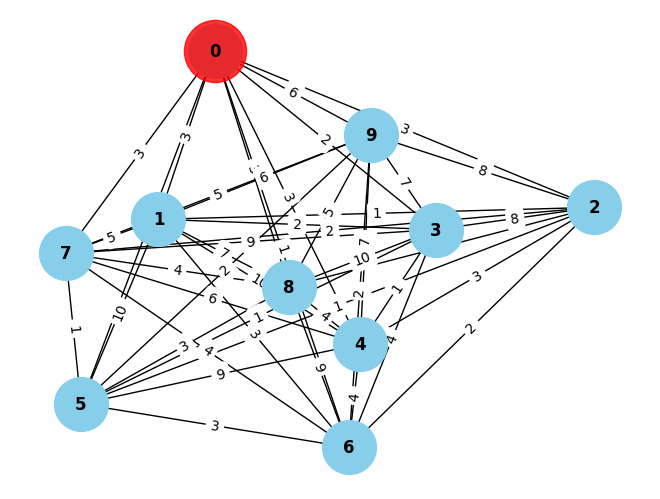

In [3]:
env = RandomWalkEnv(num_nodes=10, weight_max=10, reach_the_goal_reward=10, max_episode_length=20)
config = TrainConfig(max_eval_ep_len=20, context_len=25, rtg_range_check=(-10, 10), rtg_main=5)
traj_dataset = RandomWalkDataset(env, n_trajectories=500, reward_scale=20)

env.reset()
env.render()

model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

scheduler = torch.optim.lr_scheduler.LambdaLR(
	optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

loss_fn = nn.MSELoss(reduction='mean')

trainer = Trainer(name='random-walk-another', model=model,
				  optimizer=optimizer, loss_fn=loss_fn,
				  dataset=LimitedContextWrapper(traj_dataset, context_len=config.context_len),
				  device=device, config=config, scheduler=scheduler)

callback = CustomCallback(env=env, model=model,
						  optimizer=optimizer, logger=trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

trainer.register_callback(callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in model.parameters()))

In [4]:
report = trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -12.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-17-46-49_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-17-46-49.pt
time elapsed: 0:00:02
num of updates: 100
loss: 30.74950
eval avg reward: -12.00000
best score: -inf
eval_avg_ep_len 5.00000
grad_norm 0.18698
lr 0.00001
achieved average reward:  4.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-17-46-49_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-17-46-49.pt
time elapsed: 0:00:05
num of updates: 200
loss: 14.90095
eval avg reward: 4.00000
best score: -12.00000
eval_avg_ep_len 1.00000
grad_norm 0.10605
lr 0.00002
achieved average reward:  4.0
saving max scor

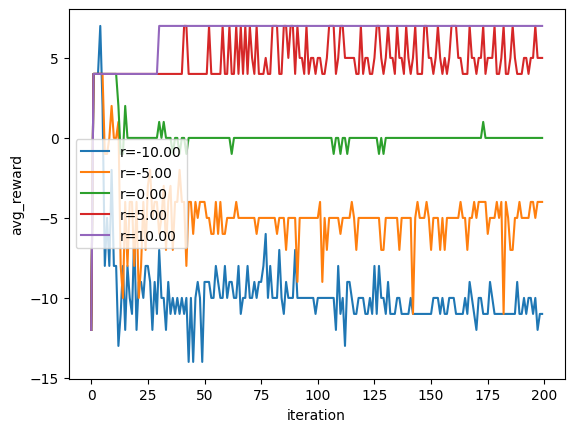

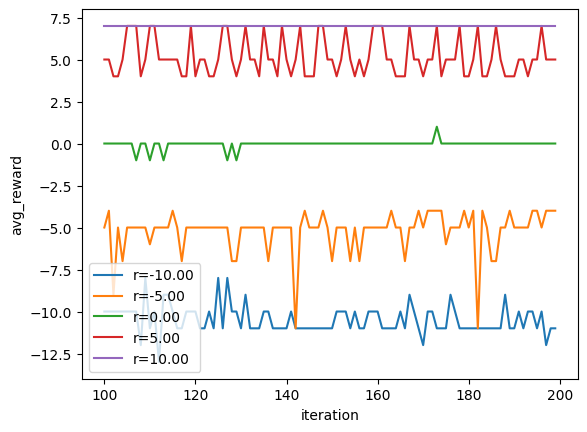

In [12]:
callback.plot_eval_results()

<Axes: >

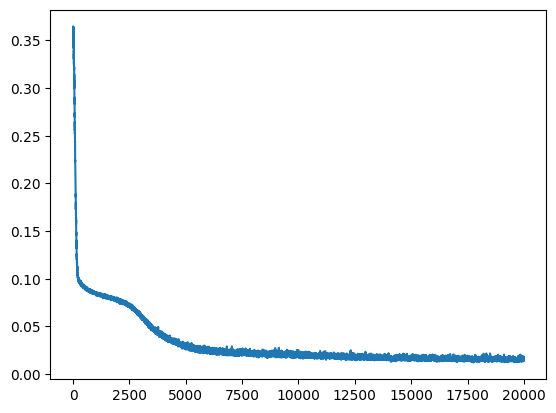

In [13]:
report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

7


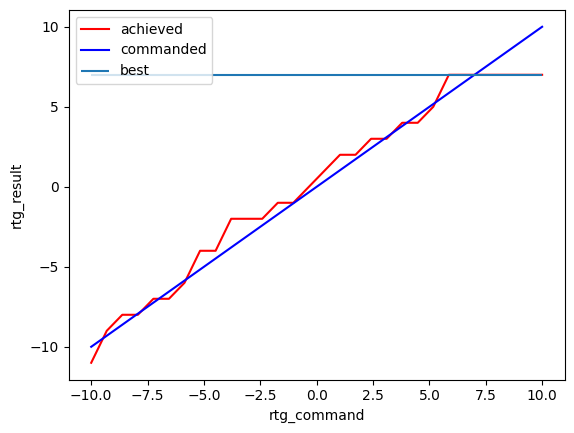

In [20]:
rtg_command = np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 30)

rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


import networkx as nx

shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(shortest_path[:-1], shortest_path[1:]))

plt.hlines(best_score, config.rtg_range_check[0], config.rtg_range_check[1])
print(best_score)
plt.legend(["achieved", "commanded", "best"])


In [8]:
ds_rewards = np.array([traj_dataset.reward_convertor.from_feature_space(traj.returns[0]) for traj in traj_dataset])

In [15]:
for traj in traj_dataset:
  if traj_dataset.reward_convertor.from_feature_space(traj.returns[0]) > 6.8:
    actions = traj_dataset.action_convertor.from_feature_space(traj.actions)
    break

actions

array([5, 9])

In [19]:
env.reach_the_goal_reward

10

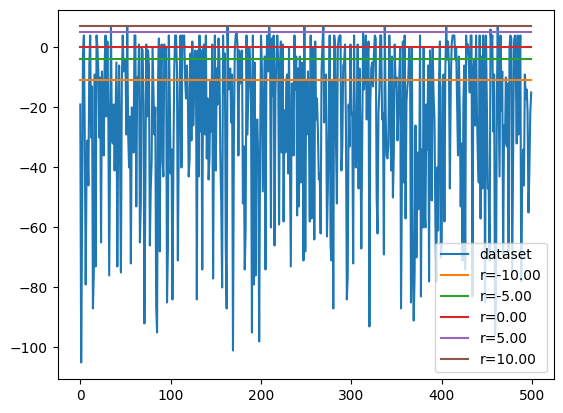

In [9]:
plt.plot(range(len(ds_rewards)), ds_rewards)

for rtg in callback.rtgs:
    plt.plot(range(len(ds_rewards)), [callback.eval_results[-1][rtg]['eval/avg_reward']]*len(ds_rewards))
plt.legend(["dataset"] + [f'r={rtg:.2f}' for rtg in callback.rtgs])

In [10]:
sorted(ds_rewards)[::-1]

[7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 7.0,
 6.0,
 5.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -1.0,
 -2.0,
 -2.0,
 -2.0,
 -2.0,
 -2.0,
 -2.0,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 -3.0,
 -4.0,
 -4.0,
 -4.0,
 -4.0,
 -4.0,
 -4.0,
 -4.0,
 -4.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -5.0,
 -6.0,
 -6.0,
 -6.0,
 -6.0,
 -6.0,
 -6

In [21]:
wrapper = LimitedContextWrapper(traj_dataset, context_len=config.context_len)
ds_without_best = []
for idx in range(len(wrapper)):
    if ds_rewards[idx] > 6.8:
        continue
    ds_without_best.append(wrapper[idx])

number of parameters 1125141


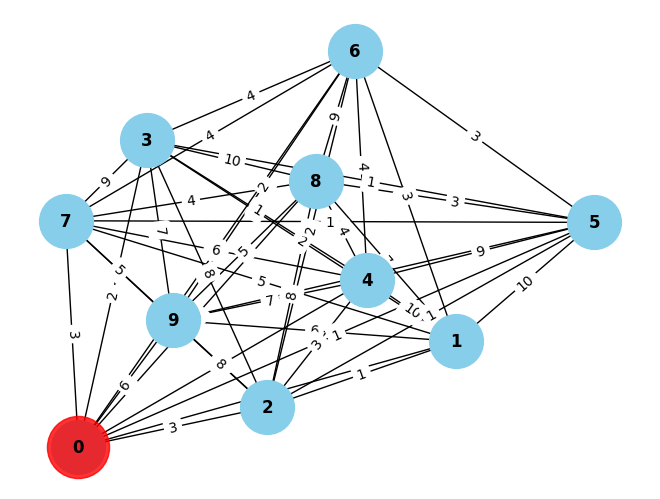

In [23]:
env.reset()
env.render()

new_model = DecisionTransformer(
			state_dim=traj_dataset.state_dim(),
			act_dim=traj_dataset.action_dim(),
			n_blocks=config.n_blocks,
			h_dim=config.embed_dim,
			context_len=config.context_len,
			n_heads=config.n_heads,
			drop_p=config.dropout_p,
).to(device)

new_optimizer = torch.optim.AdamW(new_model.parameters(), lr=config.lr, weight_decay=config.wt_decay)

new_scheduler = torch.optim.lr_scheduler.LambdaLR(
	new_optimizer,
	lambda steps: min((steps+1)/config.warmup_steps, 1)
)

new_trainer = Trainer(name='random-walk-another', model=new_model,
				  optimizer=new_optimizer, loss_fn=loss_fn,
				  dataset=ds_without_best,
				  device=device, config=config, scheduler=new_scheduler)

new_callback = CustomCallback(env=env, model=new_model,
						  optimizer=new_optimizer, logger=new_trainer.logger, device=device, traj_dataset=traj_dataset, config=config,
						  rtgs=np.linspace(config.rtg_range_check[0], config.rtg_range_check[1], 5))

new_trainer.register_callback(new_callback.callback)

print("number of parameters", sum(np.prod(param.shape) for param in new_model.parameters()))

In [24]:
new_report = new_trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

achieved average reward:  -40.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-18-03-03_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-18-03-03.pt
time elapsed: 0:00:02
num of updates: 100
loss: 28.45528
eval avg reward: -40.00000
best score: -inf
eval_avg_ep_len 12.00000
grad_norm 0.18719
lr 0.00001
achieved average reward:  4.0
saving max score model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-18-03-03_best.pt
saving current model at: /home/muhender/6.8200/RL-credit-assignment-experiment/logs/dt_runs/dt_random-walk-another_model_24-05-09-18-03-03.pt
time elapsed: 0:00:06
num of updates: 200
loss: 14.87051
eval avg reward: 4.00000
best score: -40.00000
eval_avg_ep_len 1.00000
grad_norm 0.11089
lr 0.00002
achieved average reward:  4.0
saving max sco

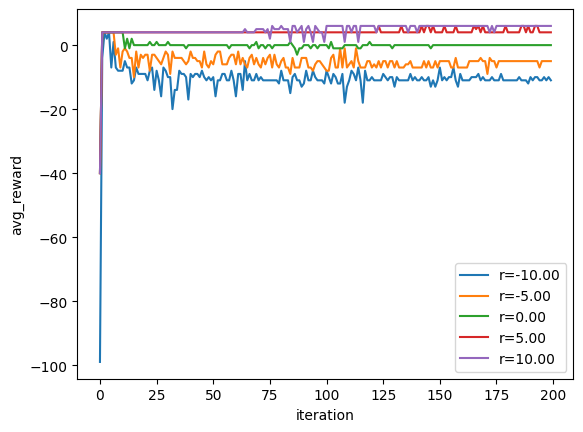

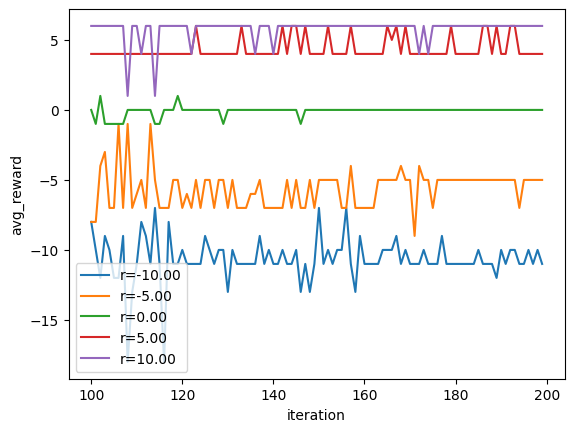

In [25]:
new_callback.plot_eval_results()

<Axes: >

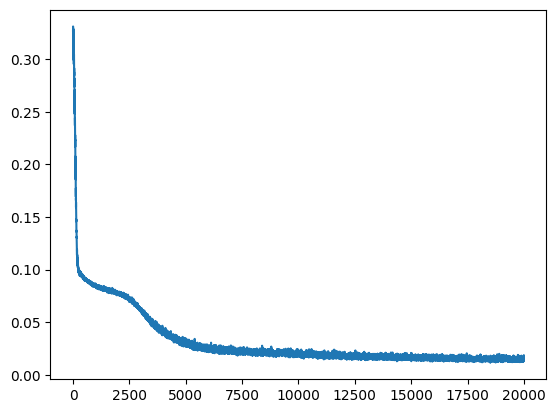

In [26]:
new_report.sort_values(by=['train/iteration', 'train/update_idx']).reset_index()['train/loss'].plot()

7


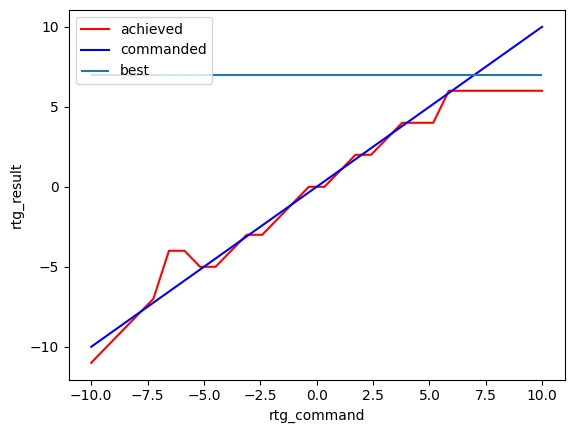

In [27]:
new_rtg_result = []

for rtg in rtg_command:
	res = evaluate_on_env(
		model=new_model,
		traj_dataset=traj_dataset,
		device=device,
		context_len=config.context_len,
		env=env,
		rtg_target=rtg,
		num_eval_ep=config.num_eval_ep
	)
	new_rtg_result.append(res['eval/avg_reward'])

plt.plot(rtg_command, new_rtg_result, 'r')
plt.plot(rtg_command, rtg_command, 'b')
plt.xlabel("rtg_command")
plt.ylabel("rtg_result")


import networkx as nx

new_shortest_path = nx.shortest_path(env.G, env.starting_vertex, env.ending_vertex, weight='weight')
new_best_score = env.reach_the_goal_reward - sum(env.G[a][b]['weight'] for a, b in zip(new_shortest_path[:-1], new_shortest_path[1:]))

plt.hlines(new_best_score, config.rtg_range_check[0], config.rtg_range_check[1])
print(new_best_score)
plt.legend(["achieved", "commanded", "best"])

In [28]:
ds_rewards_non_best = np.array([traj_dataset.reward_convertor.from_feature_space(traj.returns[0]) for traj in traj_dataset])

In [ ]:
ds_rewards_non_best

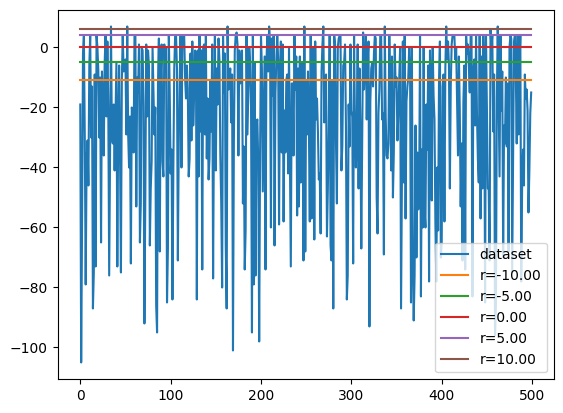

In [29]:
plt.plot(range(len(ds_rewards_non_best)), ds_rewards_non_best)

for rtg in new_callback.rtgs:
    plt.plot(range(len(ds_rewards_non_best)), [new_callback.eval_results[-1][rtg]['eval/avg_reward']]*len(ds_rewards_non_best))
plt.legend(["dataset"] + [f'r={rtg:.2f}' for rtg in new_callback.rtgs])